In [1]:
import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
from heapq import nsmallest
from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft, ifft
from scipy import integrate

### Lecture Data

In [2]:
theoric_lines = pd.read_csv('DataSet/Inputs/theoric_c_lines.txt', delimiter = '\t', header = 0)
theoric_lines['wave_peak'] = theoric_lines['wave_peak']/10
theoric_lines['wave_base'] = theoric_lines['wave_base']/10
theoric_lines['wave_top'] = theoric_lines['wave_top']/10

c_s = pd.read_csv('DataSet/Inputs/Subtracted_spectrum.txt', delimiter = '\t', header = 0)

data_klaus = pd.read_csv("DataSet/Inputs/Ti2_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1'], header = 0)

growth_c_ispec_gauss = pd.read_csv("DataSet/Outputs/Ti2_substract_ispec_gauss.dat", delimiter = '\t', usecols = ['wave_nm', 'wave_base', 'wave_top','loggf', 'ewr'], header = 0)
growth_c_ispec_voigth = pd.read_csv("DataSet/Outputs/Ti2_substract_ispec_voigth.dat", delimiter = '\t', usecols = ['wave_nm', 'wave_base', 'wave_top','loggf', 'ewr'], header = 0)

#growth_c_mine = pd.read_csv("DataSet/Outputs/Ti 2_growth_curve.dat", delimiter = '\t', header = 0)
Atomic_lines = pd.read_csv('DataSet/Inputs/atomic_lines.tsv', delimiter = '\t', usecols = ['element', 'wave_nm', 'loggf', 'lower_state_eV', 'upper_state_eV'],   header = 0, low_memory=False, keep_default_na= False)
Atomic_lines = Atomic_lines[(Atomic_lines['wave_nm']>=375) & (Atomic_lines['wave_nm']<=465)]

In [3]:
Atomic_lines

,element,wave_nm,loggf,lower_state_eV,upper_state_eV
113154,C2 1,375.0014,-8.369,1.240,4.546
113155,CH 1,375.0014,-7.477,0.360,3.666
113156,Cr 2,375.0017,-3.640,11.667,14.972
113157,C2 1,375.0038,-8.269,1.240,4.546
113158,V 1,375.0048,-2.780,1.860,5.165
...,...,...,...,...,...
253621,C2 1,464.9971,-3.836,0.971,3.637
253622,O 3,464.9973,-0.679,45.926,48.592
253623,Gd 2,464.9977,-2.280,0.602,3.267
253624,C2 1,464.9992,-3.176,0.886,3.552


In [89]:
data_klausFe1 = pd.read_csv("DataSet/Inputs/Fe1_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1'], header = 0)
data_klausTi2 = pd.read_csv("DataSet/Inputs/Ti2_data_klaus.txt", delimiter = '\t', usecols = ['lambda', 'loggf', 'ewr1'], header = 0)

growth_c_mineFe1 = pd.read_csv("DataSet/Outputs/Fe 1_growth_curve_25oct.dat", delimiter = '\t', header = 0)
growth_c_mineTi2 = pd.read_csv("DataSet/Outputs/Ti 2_growth_curve_25oct.dat", delimiter = '\t', header = 0)

## Found absortion lines

In [77]:
top = []
for i in range(len(theoric_lines['wave_top'])):
    top.append(nsmallest(1,c_s['waveobs'], key = lambda x: abs(x-theoric_lines['wave_top'][i]))[0])

In [78]:
base = []
for i in range(len(theoric_lines['wave_base'])):
    base.append(nsmallest(1,c_s['waveobs'], key = lambda x: abs(x-theoric_lines['wave_base'][i]))[0])

In [81]:
#Create new list with contain the absortion lines in cromospheric spectrum with its respective element
c_lines_spectrum = pd.DataFrame(columns = ['wave_peak', 'wave_base', 'wave_top','note', 'flux', 'error_f'])
L = []
I = []
mins = []
       
for i in range(len(base)):
    b = c_s['waveobs']>base[i]
    a = c_s['waveobs']<top[i]
    c = a&b 
    min_ = min(c_s['flux'][c])
    L.append(c_s["waveobs"][c][c_s["flux"][c] == min_].tolist()[0])
    I.append(c_s['flux'][c][c_s["flux"][c] == min_].tolist()[0])
    mins.append(min_)
    
c_lines_spectrum['wave_peak'] = L
c_lines_spectrum['wave_base'] = base
c_lines_spectrum['wave_top'] = top
c_lines_spectrum['note'] = theoric_lines['note']
c_lines_spectrum['flux'] = I
c_lines_spectrum['error_f'] = c_s['err']

In [83]:
c_lines_spectrum.to_csv("c_lines_spectrum.txt", sep='\t', index = False, header=True)

## Test Equivalent Width

#### Fit

In [107]:
#Number of splines
def step_continuum(Lmin,Lmax,splines):
    return (Lmax-Lmin)/splines

#New dots to found continuous
def Points_continuum(_lambda, Intensity,start,end,step):
    
    steps_list = np.arange(start,end, step)
    grouped_data = {}
    grouped_data['L'] = []
    grouped_data['I'] = []
    for i in range(1,len(steps_list)):
        grouped_lambda = _lambda[(_lambda >= steps_list[i-1]) & (_lambda < steps_list[i])]

        grouped_data['L'].append(grouped_lambda)
        grouped_data['I'].append(Intensity[  grouped_lambda.index  ])
    return grouped_data

#Fit contunuous to line data
def fit_continuum(grouped_data, L_min, L_max):  
    newdataL = [] 
    newdataI = []
    for i in range(len(grouped_data['I'])):
        newdataL.append(grouped_data['L'][i].median())
        newdataI.append(grouped_data['I'][i].median())
        data_fitL = [x for x in newdataL if str(x) != 'nan']
        data_fitI = [x for x in newdataI if str(x) != 'nan']
    cs = InterpolatedUnivariateSpline(data_fitL,data_fitI)
    xs =  np.linspace(L_min,  L_max, 100)
    fit =  pd.DataFrame({'L': xs, 'I': cs(xs)})
    return fit

In [135]:
step = step_continuum(Ti2_gf['wave_base'][0],Ti2_gf['wave_top'][0],20)

grouped_data = Points_continuum(c_s['waveobs'], c_s['flux'],Ti2_gf['wave_base'][0],Ti2_gf['wave_top'][0],step)

fit1 = fit_continuum(grouped_data, Ti2_gf['wave_base'][0], Ti2_gf['wave_top'][0]+0.07)
fit = fit1[(fit1['L'] >= Ti2_gf['wave_base'][0]) & (fit1['L'] <= Ti2_gf['wave_top'][0])]
fit

,L,I
0,376.075000,1.273505
1,376.077071,1.229357
2,376.079141,1.176255
3,376.081212,1.115694
4,376.083283,1.049175
...,...,...
61,376.201313,0.951128
62,376.203384,0.875268
63,376.205455,0.754169
64,376.207525,0.582042


#### Pseudocontinuou

In [120]:
def pseudocontinuou(Data,LMIN, LMAX):
    pseudo_continuous1 = c_s[(c_s['waveobs'] <= LMIN)  & (c_s['waveobs'] > (LMIN-0.05))]
    pseudo_continuous2 = c_s[(c_s['waveobs'] >= LMAX )  & (c_s['waveobs'] < (LMAX+0.05))]
    pseudo_continuous1.index = list(range(len(pseudo_continuous1)))
    pseudo_continuous2.index = list(range(len(pseudo_continuous2)))

    mean1 = np.mean(pseudo_continuous1)
    mean2 = np.mean(pseudo_continuous2)
    mean = (mean1['flux'] + mean2['flux'])/2
    return mean

In [121]:
mean = pseudocontinuou(c_s, Ti2_gf['wave_base'][0], Ti2_gf['wave_top'][0])

## Graph

### Equivalent width

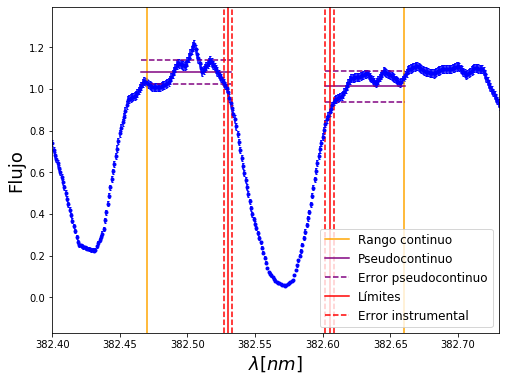

In [11]:
plt.figure(figsize = [8,6])

(_, caps, _) = plt.errorbar(c_s['waveobs'],c_s['flux'],c_s['err'], 0, color = 'blue', marker='.',ls = '',capsize=1)

for cap in caps:
    cap.set_markeredgewidth(1)
    
#plt.plot(c_s['waveobs'][7590],c_s['flux'][7590], color = 'red',marker='o', ls='', label = 'mins')

plt.xlim(382.4,382.73)

plt.axvline(382.47, color = 'orange', label ='Rango continuo')
plt.axhline(c_s['flux'][7490:7551].mean(), color = 'purple', xmin=0.2, xmax=0.4, label ='Pseudocontinuo' )
plt.axhline(c_s['flux'][7490:7551].mean() + c_s['flux'][7490:7551].std(), ls ='--', color = 'purple', xmin=0.2, xmax=0.4, label ='Error pseudocontinuo' )
plt.axhline(c_s['flux'][7490:7551].mean() - c_s['flux'][7490:7551].std(), ls ='--',color = 'purple', xmin=0.2, xmax=0.4 )


plt.axvline(382.53, color = 'red', label ='Límites')
plt.axvline(382.527, color = 'red', ls='--', label ='Error instrumental')
plt.axvline(382.533, color = 'red', ls='--')


plt.axvline(382.66, color = 'orange')

plt.axhline(c_s['flux'][7620:7680].mean(), color = 'purple', xmin=0.61, xmax=0.79)
plt.axhline(c_s['flux'][7620:7680].mean() + c_s['flux'][7620:7680].std(), ls ='--',color = 'purple', xmin=0.61, xmax=0.79)
plt.axhline(c_s['flux'][7620:7680].mean() - c_s['flux'][7620:7680].std(), ls ='--',color = 'purple', xmin=0.61, xmax=0.79)

plt.axvline(382.605, color = 'red')
plt.axvline(382.602, color = 'red', ls='--')
plt.axvline(382.608, color = 'red', ls='--')


#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2, color = 'magenta')


#plt.ylim(-2.5, 3)
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
plt.legend(fontsize = 12)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


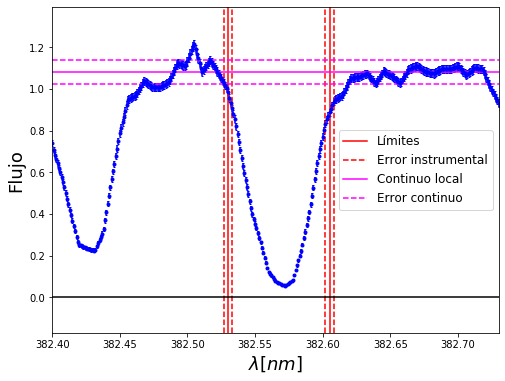

In [8]:
plt.figure(figsize = [8,6])

(_, caps, _) = plt.errorbar(c_s['waveobs'],c_s['flux'],c_s['err'], 0, color = 'blue', marker='.',ls = '',capsize=1)

for cap in caps:
    cap.set_markeredgewidth(1)
    

plt.axvline(382.53, color = 'red', label ='Límites')
plt.axvline(382.527, color = 'red', ls='--', label ='Error instrumental')
plt.axvline(382.533, color = 'red', ls='--')


plt.axvline(382.605, color = 'red')
plt.axvline(382.602, color = 'red', ls='--')
plt.axvline(382.608, color = 'red', ls='--')


#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2, color = 'magenta', label='Continuo local')
#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2 + (c_s['flux'][7620:7680].std() +c_s['flux'][7490:7551].std())/2, ls='--', color = 'magenta', label = 'Error de Continuo' )
#plt.axhline((c_s['flux'][7490:7551].mean() + c_s['flux'][7620:7680].mean())/2 - (c_s['flux'][7620:7680].std() +c_s['flux'][7490:7551].std())/2, ls='--', color = 'magenta')

plt.axhline(c_s['flux'][7490:7551].mean(), color = 'magenta', label='Continuo local')
plt.axhline(c_s['flux'][7490:7551].mean() + c_s['flux'][7490:7551].std(), ls ='--', color = 'magenta', label ='Error continuo' )
plt.axhline(c_s['flux'][7490:7551].mean() - c_s['flux'][7490:7551].std(), ls ='--',color = 'magenta' )

plt.axhline(0, color = 'black')

#plt.ylim(-2.5, 3)
plt.xlim(382.4,382.73)
#plt.grid()
#plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
plt.legend(fontsize = 12)
plt.show()

In [20]:
growth_c_mineF1

,wave_peak,wave_base,wave_top,note,flux,loggf,lower_state_eV,upper_state_eV,EW,EWR,error_f,errEWR,loggf_klaus
0,376.385,376.318,376.410,Fe 1,0.106631,-0.238,0.990,4.283,0.036252,-4.016306,0.043812,0.087915,-0.21
1,376.727,376.660,376.735,Fe 1,0.145955,-0.389,1.011,4.301,0.024948,-4.178982,0.044726,0.221430,-0.34
2,378.797,378.736,378.798,Fe 1,0.387217,-0.859,1.011,4.283,0.006957,-4.736007,0.045639,0.417420,-0.77
3,379.509,379.449,379.512,Fe 1,0.215285,-0.761,0.990,4.256,0.013014,-4.464798,0.044243,0.369004,-0.65
4,379.961,379.887,379.974,Fe 1,0.167045,-0.846,0.958,4.220,0.004144,-4.962300,0.042700,2.169544,NaN
5,381.595,381.525,381.615,Fe 1,0.218927,0.237,1.485,4.733,0.029944,-4.105296,0.041158,0.132667,0.35
6,382.041,381.971,382.082,Fe 1,0.074266,0.119,0.859,4.103,0.056022,-3.833754,0.039619,0.014633,-0.04
7,382.455,382.387,382.467,Fe 1,0.257325,-1.362,0.000,3.241,0.029598,-4.111318,0.038082,0.122944,NaN
8,382.596,382.518,382.646,Fe 1,0.089451,-0.037,0.915,4.154,0.039075,-3.990843,0.036548,0.113371,NaN
9,382.791,382.720,382.795,Fe 1,0.261648,0.062,1.557,4.796,0.016639,-4.361826,0.035463,0.230305,NaN


In [74]:
growth_c_mineFe1 = growth_c_mineFe1[~growth_c_mineFe1.index.isin([4,11])]
growth_c_mineFe1.index = list(range(len(growth_c_mineFe1)))

In [14]:
growth_c_mine1 = growth_c_mine1[~growth_c_mine1.index.isin([11,17])]
growth_c_mine1.index = list(range(len(growth_c_mine1)))

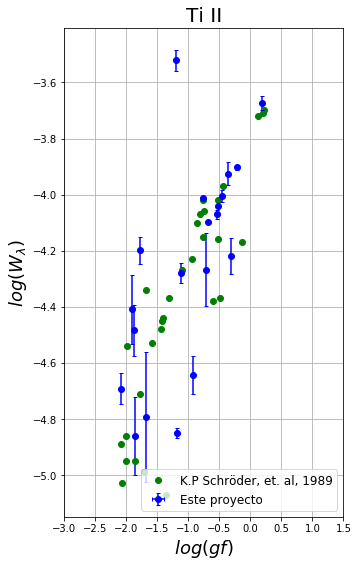

In [90]:
plt.figure(figsize = [5,9])
#plt.plot(growth_c_ispec_voigth['loggf'],growth_c_ispec_voigth['ewr'],marker='o', ls='', label = 'ispec_voigt')
#plt.plot(growth_c_ispec_gauss['loggf'],growth_c_ispec_gauss['ewr'],marker='o', ls='', label = 'ispec_gauss')
#plt.plot(,marker='o', color = 'r', ls='', label = 'Lucía')
plt.plot(data_klausTi2['loggf'],data_klausTi2['ewr1'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(growth_c_mineTi2['loggf'],growth_c_mineTi2['EWR'],growth_c_mineTi2['errEWR']*0.6, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')
#(_, caps, _) = plt.errorbar(growth_c_mineF1['loggf_klaus'],growth_c_mineF1['EWR'],growth_c_mineF1['errEWR']*0.4, 0, color = 'purple', marker='o',ls = '',capsize=2,label = 'prueba nueva')

for cap in caps:
    cap.set_markeredgewidth(1)
    
#plt.plot(growth_c_mine1['loggf'],growth_c_mine1['EWR'],marker='o', ls='', color = 'red', label = 'nueva prueba')

#plt.plot(fit1['L'],fit1['I'],marker='', ls='-', label = 'fit')
    
plt.xlim(-3,1.5)
#plt.ylim(-5, -3.8)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Ti II',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

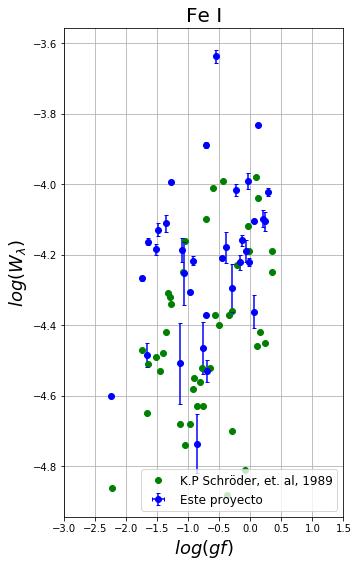

In [77]:
plt.figure(figsize = [5,9])
#plt.plot(growth_c_ispec_voigth['loggf'],growth_c_ispec_voigth['ewr'],marker='o', ls='', label = 'ispec_voigt')
#plt.plot(growth_c_ispec_gauss['loggf'],growth_c_ispec_gauss['ewr'],marker='o', ls='', label = 'ispec_gauss')
#plt.plot(,marker='o', color = 'r', ls='', label = 'Lucía')
plt.plot(data_klausFe1['loggf'],data_klausFe1['ewr1'],marker='o', ls='', color = 'green', label = 'K.P Schröder, et. al, 1989')

(_, caps, _) = plt.errorbar(growth_c_mineFe1['loggf'],growth_c_mineFe1['EWR'],growth_c_mineFe1['errEWR']*0.2, 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Este proyecto')
#(_, caps, _) = plt.errorbar(growth_c_mineF1['loggf_klaus'],growth_c_mineF1['EWR'],growth_c_mineF1['errEWR']*0.4, 0, color = 'purple', marker='o',ls = '',capsize=2,label = 'prueba nueva')

for cap in caps:
    cap.set_markeredgewidth(1)
    
#plt.plot(growth_c_mine1['loggf'],growth_c_mine1['EWR'],marker='o', ls='', color = 'red', label = 'nueva prueba')

#plt.plot(fit1['L'],fit1['I'],marker='', ls='-', label = 'fit')
    
plt.xlim(-3,1.5)
#plt.ylim(-5, -3.8)
plt.grid()
plt.legend(loc="best", fontsize=12)
plt.title('Fe I',fontsize=20)
plt.ylabel("$log(W_{\lambda})$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [85]:
growth_c_mineTi2  = growth_c_mineTi2[~growth_c_mineTi2.index.isin([11])]
growth_c_mineTi2.index = list(range(len(growth_c_mineTi2)))

In [86]:
def Growth_theoric(gf,_lambda,E_i,T_exc):
    return gf*_lambda*np.exp(-E_i/T_exc)/(27.0)

#a = Growth_theoric(10**(growth_c_mine['loggf'][0]), growth_c_mine['wave_peak'][0], (growth_c_mine['upper_state_eV'][0] - growth_c_mine['lower_state_eV'][0] ), 5000)


theoretical_curve = []
for i in range(0,len(growth_c_mineTi2['loggf'])):
    theoretical_curve.append(Growth_theoric(10**(growth_c_mineTi2['loggf'][i]), growth_c_mineTi2['wave_peak'][i], (growth_c_mineTi2['upper_state_eV'][i] - growth_c_mineTi2['lower_state_eV'][i] ), 5000))

    
def ajuste(x,a,b):
    return a*x + b

popt1, pcov1 = scipy.optimize.curve_fit(ajuste, np.log(theoretical_curve), growth_c_mineTi2['EWR'])

xfit = np.linspace(min(np.log(theoretical_curve)), max(np.log(theoretical_curve)), 100)
yfit = ajuste(xfit,*popt1)

In [29]:
growth_c_mine = growth_c_mine[~growth_c_mine.index.isin([15])]
growth_c_mine.index = list(range(len(growth_c_mine)))


In [78]:
max(np.log(theoretical_curve))

3.0478697159337784

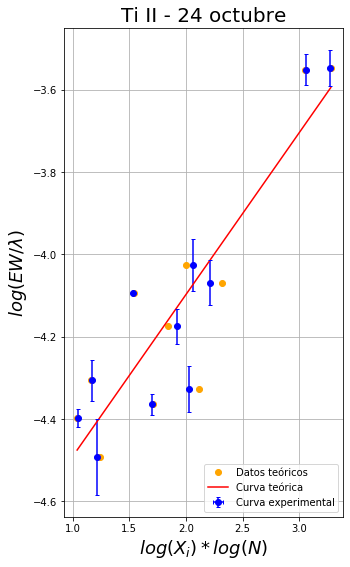

In [88]:
plt.figure(figsize = [5,9])
#plt.plot(growth_c_ispec_voigth['loggf'],growth_c_ispec_voigth['ewr'],marker='o', ls='', label = 'ispec_voigt')
#plt.plot(growth_c_ispec_gauss['loggf'],growth_c_ispec_gauss['ewr'],marker='o', ls='', label = 'ispec_gauss')
plt.plot(np.log(theoretical_curve), growth_c_mineTi2['EWR'],marker='o', color = 'orange', ls='', label = 'Datos teóricos')
plt.plot(xfit,yfit,marker='', ls='-', color = 'red', label = 'Curva teórica')
(_, caps, _) = plt.errorbar((growth_c_mineTi2['loggf']*2.12+2.68),growth_c_mineTi2['EWR'],growth_c_mineTi2['errEWR'], 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

for cap in caps:
    cap.set_markeredgewidth(1)
#plt.plot(xfit,yfit,marker='', ls='--', color = 'green', label = 'Klaus')


#(_, caps, _) = plt.errorbar(growth_c_mine['loggf'],growth_c_mine['EWR'],growth_c_mine['errEWR'], 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva Experimental')

#for cap in caps:
#    cap.set_markeredgewidth(1)
    
#plt.xlim(-4,25)
#plt.ylim(-6, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Ti II - 24 octubre',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(X_i)*log(N)$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [ ]:
plt.figure(figsize = [5,9])
#plt.plot(growth_c_ispec_voigth['loggf'],growth_c_ispec_voigth['ewr'],marker='o', ls='', label = 'ispec_voigt')
#plt.plot(growth_c_ispec_gauss['loggf'],growth_c_ispec_gauss['ewr'],marker='o', ls='', label = 'ispec_gauss')
#plt.plot(,marker='o', color = 'r', ls='', label = 'Lucía')
plt.plot(np.log(theoretical_curve),growth_c_mine['EWR'],marker='o', ls='', color = 'green', label = 'Curva teórica')
plt.plot(xfit,yfit,marker='', ls='-', color = 'red', label = 'Curva teórica')

#plt.plot(xfit,yfit,marker='', ls='--', color = 'green', label = 'Klaus')


(_, caps, _) = plt.errorbar((growth_c_mine['loggf']*2.6 +2.9),growth_c_mine['EWR'],growth_c_mine['errEWR'], 0, color = 'blue', marker='o',ls = '',capsize=2,label = 'Curva experimental')

for cap in caps:
    cap.set_markeredgewidth(1)
    
#plt.xlim(-20,25)
#plt.ylim(-6, -3.5)
plt.grid()
plt.legend(loc="lower right")
plt.title('Ti 2',fontsize=20)
plt.ylabel("$log(EW/\lambda)$",fontsize=18)
plt.xlabel("$log(gf)$",fontsize=18)
#plt.xscale('log')

plt.legend(fontsize = 12)
plt.show()

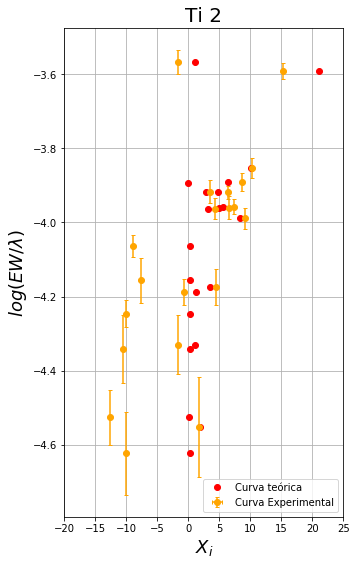

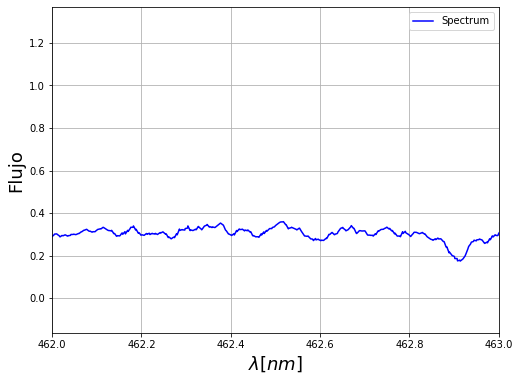

In [662]:
plt.figure(figsize = [8,6])

plt.plot(c_s['waveobs'],c_s['flux'],color = 'blue', marker='',ls = '-',label = 'Spectrum')


plt.axvline(458.31, color = 'red')
plt.axvline(458.416, color = 'red')

plt.xlim(462, 463)
plt.grid()
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [nm]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [3]:
b = c_s['waveobs']>376.075
a = c_s['waveobs']<376.210
c = a&b
errorA2 = np.sqrt(np.sum(c_s['err'][c]**2))

In [4]:
errorA2

0.20710838958897468

In [26]:
1.2*(0.05/1.2)*((0.03 + 0.03)/(0.1))

0.03

In [12]:
np.sqrt(np.sum(c_s['err'][c]**2))

0.20710838958897468